<a href="https://colab.research.google.com/github/alamintalukdercsejnu/BTC-DL/blob/main/Brain_Tumor_Classification_using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
import zipfile
import numpy as np
from scipy.io import loadmat
from PIL import Image

# Step 1: Download the Dataset
url = 'https://figshare.com/ndownloader/articles/1512427/versions/8'
output_path = 'brain_tumor_dataset.zip'

print("Downloading dataset...")
response = requests.get(url)
with open(output_path, 'wb') as file:
    file.write(response.content)
print("Download completed.")

# Step 2: Extract the Dataset
extract_dir = 'brain_tumor_dataset'
os.makedirs(extract_dir, exist_ok=True)

print("Extracting dataset...")
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extraction completed. Files are extracted to '{extract_dir}' directory.")

# Verify the structure
print("\nDirectory Structure After Extraction:")
for root, dirs, files in os.walk(extract_dir):
    print(root, "contains", len(files), "files")

Download completed.
Extracting dataset...
Extraction completed. Files are extracted to 'brain_tumor_dataset' directory.

Directory Structure After Extraction:
brain_tumor_dataset contains 6 files
Dataset path 'brain_tumor_dataset/figsharebraintumordataset/figsharedataset' not found. Verify extraction.
Conversion and organization completed.

--- Input Directory Image Counts ---
glioma - 0 images in 'figshare' directory
meningioma - 0 images in 'figshare' directory
pituitary - 0 images in 'figshare' directory


In [ ]:
import zipfile
import os

base_dir = '/content/brain_tumor_dataset/'
extract_dir = os.path.join(base_dir, 'extracted')

# Make sure extraction directory exists
os.makedirs(extract_dir, exist_ok=True)

# List all .zip files in base_dir
zip_files = [f for f in os.listdir(base_dir) if f.endswith('.zip')]
print(f"Found {len(zip_files)} zip files:")

for zip_file in zip_files:
    zip_path = os.path.join(base_dir, zip_file)
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted {zip_file} to {extract_dir}")

print(f"\nExtraction completed. Total files extracted: {len(os.listdir(extract_dir))}")


Found 4 zip files:
Extracting /content/brain_tumor_dataset/brainTumorDataPublic_767-1532.zip ...
Extracted brainTumorDataPublic_767-1532.zip to /content/brain_tumor_dataset/extracted
Extracting /content/brain_tumor_dataset/brainTumorDataPublic_1-766.zip ...
Extracted brainTumorDataPublic_1-766.zip to /content/brain_tumor_dataset/extracted
Extracting /content/brain_tumor_dataset/brainTumorDataPublic_2299-3064.zip ...
Extracted brainTumorDataPublic_2299-3064.zip to /content/brain_tumor_dataset/extracted
Extracting /content/brain_tumor_dataset/brainTumorDataPublic_1533-2298.zip ...
Extracted brainTumorDataPublic_1533-2298.zip to /content/brain_tumor_dataset/extracted

Extraction completed. Total files extracted: 3064


A single .mat file consists of:

PID: Patient ID for that particular tumor image. This is not a necessary feature.
image: Image of the brain tumor
label: Label between 1-3 denoting what kind of tumor is present
tumorBorder: Coordinates of the tumor present in the image
tumorMask: Masked version of the tumor.
We'll need the image, label, tumorBorder, tumorMask which are the necessary features that'll help us to detect brain tumors.

In [ ]:
/content/brain_tumor_dataset/extracted/1.mat

In [ ]:
import h5py
import os

mat_dir = '/content/brain_tumor_dataset/extracted'
problem_files = ['1171.mat', '545.mat']  # files with errors

for file_name in problem_files:
    file_path = os.path.join(mat_dir, file_name)
    try:
        with h5py.File(file_path, 'r') as f:
            print(f"Keys in {file_name}:")
            def printname(name):
                print(name)
            f.visit(printname)
            print("-" * 40)
    except Exception as e:
        print(f"Could not open {file_name}: {e}")


Keys in 1171.mat:
cjdata
cjdata/PID
cjdata/image
cjdata/label
cjdata/tumorBorder
cjdata/tumorMask
----------------------------------------
Keys in 545.mat:
cjdata
cjdata/PID
cjdata/image
cjdata/label
cjdata/tumorBorder
cjdata/tumorMask
----------------------------------------


In [ ]:
import h5py
import numpy as np

file_path = '/content/brain_tumor_dataset/extracted/1171.mat'

with h5py.File(file_path, 'r') as f:
    cjdata = f['cjdata']

    # Access 'label'
    label_ref = cjdata['label'][()]  # This is an object reference or array

    # Dereference label if it's a reference
    if isinstance(label_ref, np.ndarray) and label_ref.dtype == 'object':
        label_ref = label_ref[0]

    # If label_ref is a h5py reference, dereference it
    if isinstance(label_ref, h5py.Reference):
        label_data = f[label_ref][()]
    else:
        label_data = label_ref

    print("Label data:", label_data)

    # Similarly for 'image'
    image_ref = cjdata['image'][()]
    if isinstance(image_ref, np.ndarray) and image_ref.dtype == 'object':
        image_ref = image_ref[0]
    if isinstance(image_ref, h5py.Reference):
        image_data = f[image_ref][()]
    else:
        image_data = image_ref

    print("Image data shape:", image_data.shape)


Label data: [[3.]]
Image data shape: (512, 512)


In [ ]:
import h5py
import numpy as np

file_path = '/content/brain_tumor_dataset/extracted/1171.mat'

with h5py.File(file_path, 'r') as f:
    cjdata = f['cjdata']

    def dereference(ref):
        """ Dereference object references. """
        if isinstance(ref, np.ndarray) and ref.dtype == 'object':
            ref = ref[0]  # Extract the actual reference
        if isinstance(ref, h5py.Reference):
            return f[ref][()]
        return ref

    # Access 'label'
    label_ref = cjdata['label'][()]
    label_data = dereference(label_ref)

    # Convert label to integer if possible
    try:
        label = int(label_data.squeeze())
        print("Label:", label)
    except (ValueError, TypeError):
        print("Error: Invalid label data format")
        label = None

    # Access 'image'
    image_ref = cjdata['image'][()]
    image_data = dereference(image_ref)

    if isinstance(image_data, np.ndarray):
        print("Image data shape:", image_data.shape)
    else:
        print("Error: Image data is not a valid numpy array")


Label: 3
Image data shape: (512, 512)


In [ ]:
import h5py
import numpy as np
from PIL import Image
import os

def save_image(np_array, path):
    # Save directly as uint16 or uint8 depending on dtype
    # If your data is float or other, cast to uint16 without normalization
    if np_array.dtype != np.uint8:
        if np_array.dtype == np.float32 or np_array.dtype == np.float64:
            # Convert float to uint16 by scaling to max of uint16
            np_array = (np_array * 65535).astype(np.uint16)
        else:
            np_array = np_array.astype(np.uint16)
    img = Image.fromarray(np_array)
    img.save(path)

def extract_data_from_mat(mat_path, output_folder):
    with h5py.File(mat_path, 'r') as f:
        cjdata = f['cjdata']

        def dereference(name):
            ref = cjdata[name][()]
            if isinstance(ref, np.ndarray) and ref.dtype == 'object':
                ref = ref[0]
            if isinstance(ref, h5py.Reference):
                return f[ref][()]
            return ref

        image_data = dereference('image')
        label_data = dereference('label')
        tumor_border = dereference('tumorBorder')
        tumor_mask = dereference('tumorMask')

        # Convert label_data to int
        label = int(label_data.squeeze())

        # Save image as PNG without normalization
        os.makedirs(output_folder, exist_ok=True)
        file_base = os.path.splitext(os.path.basename(mat_path))[0]
        image_path = os.path.join(output_folder, f"{file_base}.png")

        save_image(image_data, image_path)

        # print(f"Saved image for {mat_path} with label {label}")

        return {
            'image_path': image_path,
            'label': label,
            'tumor_border': tumor_border,
            'tumor_mask': tumor_mask
        }

# Example usage:
mat_dir = '/content/brain_tumor_dataset/extracted'
output_dir = '/content/brain_tumor_dataset/images'

# Process all .mat files in the directory
for fname in os.listdir(mat_dir):
    if fname.endswith('.mat'):
        mat_path = os.path.join(mat_dir, fname)
        try:
            info = extract_data_from_mat(mat_path, output_dir)
        except Exception as e:
            print(f"Failed to process {fname}: {e}")


Saved image for /content/brain_tumor_dataset/extracted/1283.mat with label 3
Saved image for /content/brain_tumor_dataset/extracted/1426.mat with label 3
Saved image for /content/brain_tumor_dataset/extracted/10.mat with label 1
Saved image for /content/brain_tumor_dataset/extracted/680.mat with label 1
Saved image for /content/brain_tumor_dataset/extracted/1717.mat with label 3
Saved image for /content/brain_tumor_dataset/extracted/1781.mat with label 3
Saved image for /content/brain_tumor_dataset/extracted/2868.mat with label 2
Saved image for /content/brain_tumor_dataset/extracted/461.mat with label 1
Saved image for /content/brain_tumor_dataset/extracted/2875.mat with label 2
Saved image for /content/brain_tumor_dataset/extracted/1383.mat with label 3
Saved image for /content/brain_tumor_dataset/extracted/1166.mat with label 3
Saved image for /content/brain_tumor_dataset/extracted/244.mat with label 1
Saved image for /content/brain_tumor_dataset/extracted/888.mat with label 2
Saved

In [ ]:
# !rm -r '/content/brain_tumor_dataset/images'

In [ ]:
import h5py
import numpy as np
from PIL import Image
import os

def save_image(np_array, path):
    """Save the image without normalization or preprocessing."""
    # Save directly as uint16 or uint8 depending on dtype
    if np_array.dtype != np.uint8:
        if np_array.dtype == np.float32 or np_array.dtype == np.float64:
            # Convert float to uint16 by scaling to max of uint16
            np_array = (np_array * 65535).astype(np.uint16)
        else:
            np_array = np_array.astype(np.uint16)
    img = Image.fromarray(np_array)
    img.save(path)

def extract_data_from_mat(mat_path, output_base_folder):
    """Extract image and label from .mat file and save based on label."""
    try:
        with h5py.File(mat_path, 'r') as f:
            cjdata = f['cjdata']

            def dereference(name):
                ref = cjdata[name][()]
                if isinstance(ref, np.ndarray) and ref.dtype == 'object':
                    ref = ref[0]
                if isinstance(ref, h5py.Reference):
                    return f[ref][()]
                return ref

            # Extract image, label, tumor border, and tumor mask
            image_data = dereference('image')
            label_data = dereference('label')

            # Convert label_data to integer
            label = int(label_data.squeeze())

            # Create the label-specific folder if it doesn't exist
            output_folder = os.path.join(output_base_folder, str(label))
            os.makedirs(output_folder, exist_ok=True)

            # Save the image in the respective label folder
            file_base = os.path.splitext(os.path.basename(mat_path))[0]
            image_path = os.path.join(output_folder, f"{file_base}.png")
            save_image(image_data, image_path)

            print(f"Saved image for {mat_path} with label {label} at {image_path}")
            return {
                'image_path': image_path,
                'label': label
            }

    except Exception as e:
        print(f"Failed to process {mat_path}: {e}")

# Set directories
mat_dir = '/content/brain_tumor_dataset/extracted'
output_dir = '/content/brain_tumor_dataset/images'

# Process all .mat files in the directory
for fname in os.listdir(mat_dir):
    if fname.endswith('.mat'):
        mat_path = os.path.join(mat_dir, fname)
        extract_data_from_mat(mat_path, output_dir)

print("Processing complete.")


Saved image for /content/brain_tumor_dataset/extracted/1283.mat with label 3 at /content/brain_tumor_dataset/images/3/1283.png
Saved image for /content/brain_tumor_dataset/extracted/1426.mat with label 3 at /content/brain_tumor_dataset/images/3/1426.png
Saved image for /content/brain_tumor_dataset/extracted/10.mat with label 1 at /content/brain_tumor_dataset/images/1/10.png
Saved image for /content/brain_tumor_dataset/extracted/680.mat with label 1 at /content/brain_tumor_dataset/images/1/680.png
Saved image for /content/brain_tumor_dataset/extracted/1717.mat with label 3 at /content/brain_tumor_dataset/images/3/1717.png
Saved image for /content/brain_tumor_dataset/extracted/1781.mat with label 3 at /content/brain_tumor_dataset/images/3/1781.png
Saved image for /content/brain_tumor_dataset/extracted/2868.mat with label 2 at /content/brain_tumor_dataset/images/2/2868.png
Saved image for /content/brain_tumor_dataset/extracted/461.mat with label 1 at /content/brain_tumor_dataset/images/1/

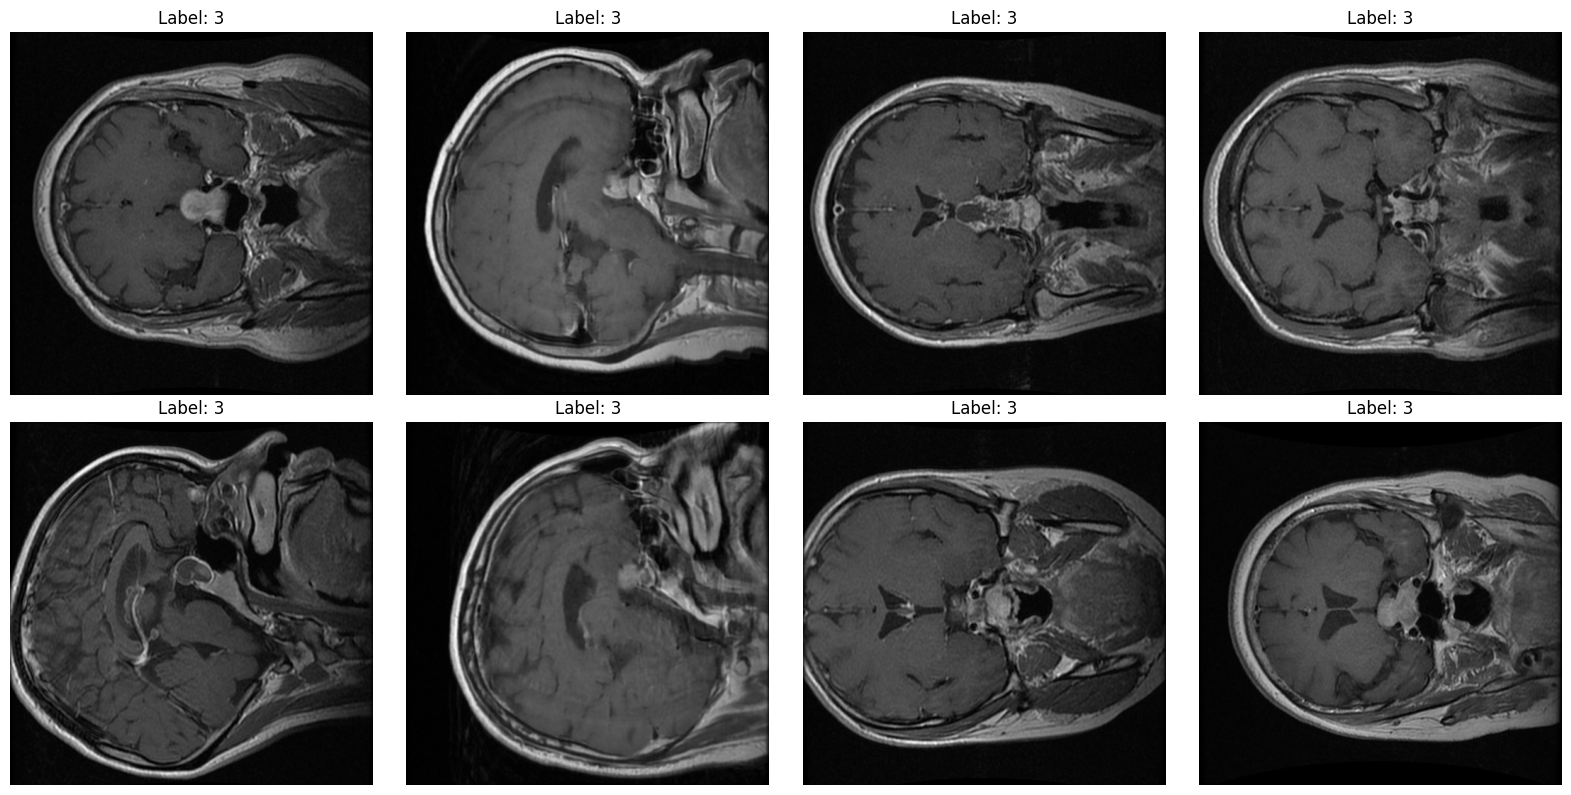

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

output_dir = '/content/brain_tumor_dataset/images'

# Collect image paths and their labels
image_files = []
labels = []

for root, _, files in os.walk(output_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            # Extract label from the subdirectory name
            label = os.path.basename(os.path.dirname(image_path))
            image_files.append(image_path)
            labels.append(label)

# Show first 8 images
num_images = min(8, len(image_files))
images_to_show = image_files[:num_images]
labels_to_show = labels[:num_images]

# Set up the plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (img_path, label) in enumerate(zip(images_to_show, labels_to_show)):
    img = Image.open(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

# Hide any unused subplots if less than 8 images
for j in range(i + 1, 8):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


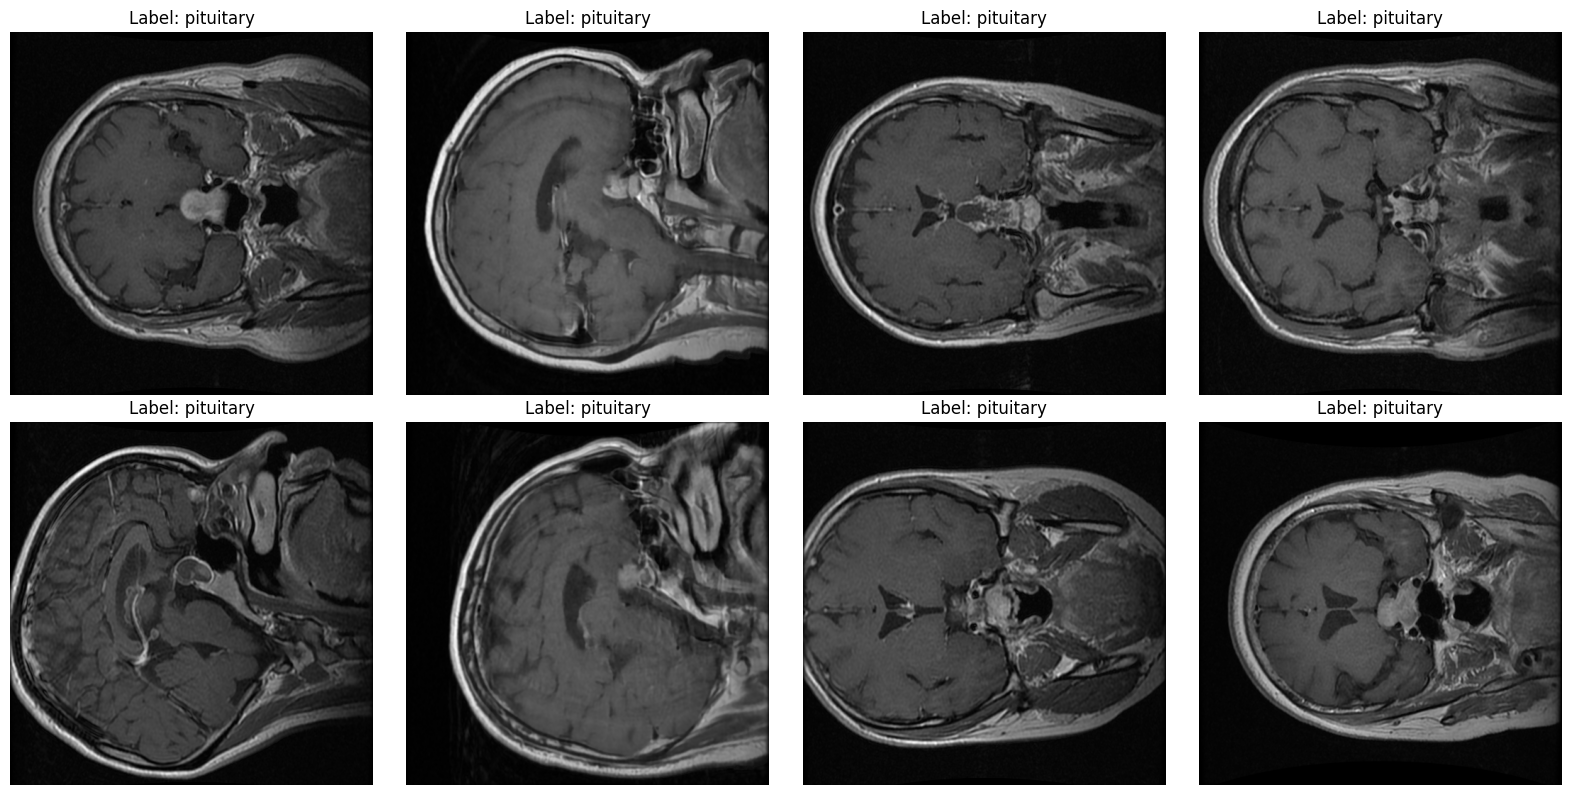

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Dictionary mapping numeric labels to tumor types
label_dict = {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}

output_dir = '/content/brain_tumor_dataset/images'

# Collect image paths and their labels
image_files = []
labels = []

for root, _, files in os.walk(output_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            # Extract numeric label from the subdirectory name
            label_num = os.path.basename(os.path.dirname(image_path))

            # Convert to integer and map to tumor type
            label_str = label_dict.get(int(label_num), "Unknown")

            image_files.append(image_path)
            labels.append(label_str)

# Show first 8 images
num_images = min(8, len(image_files))
images_to_show = image_files[:num_images]
labels_to_show = labels[:num_images]

# Set up the plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (img_path, label) in enumerate(zip(images_to_show, labels_to_show)):
    img = Image.open(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

# Hide any unused subplots if less than 8 images
for j in range(i + 1, 8):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


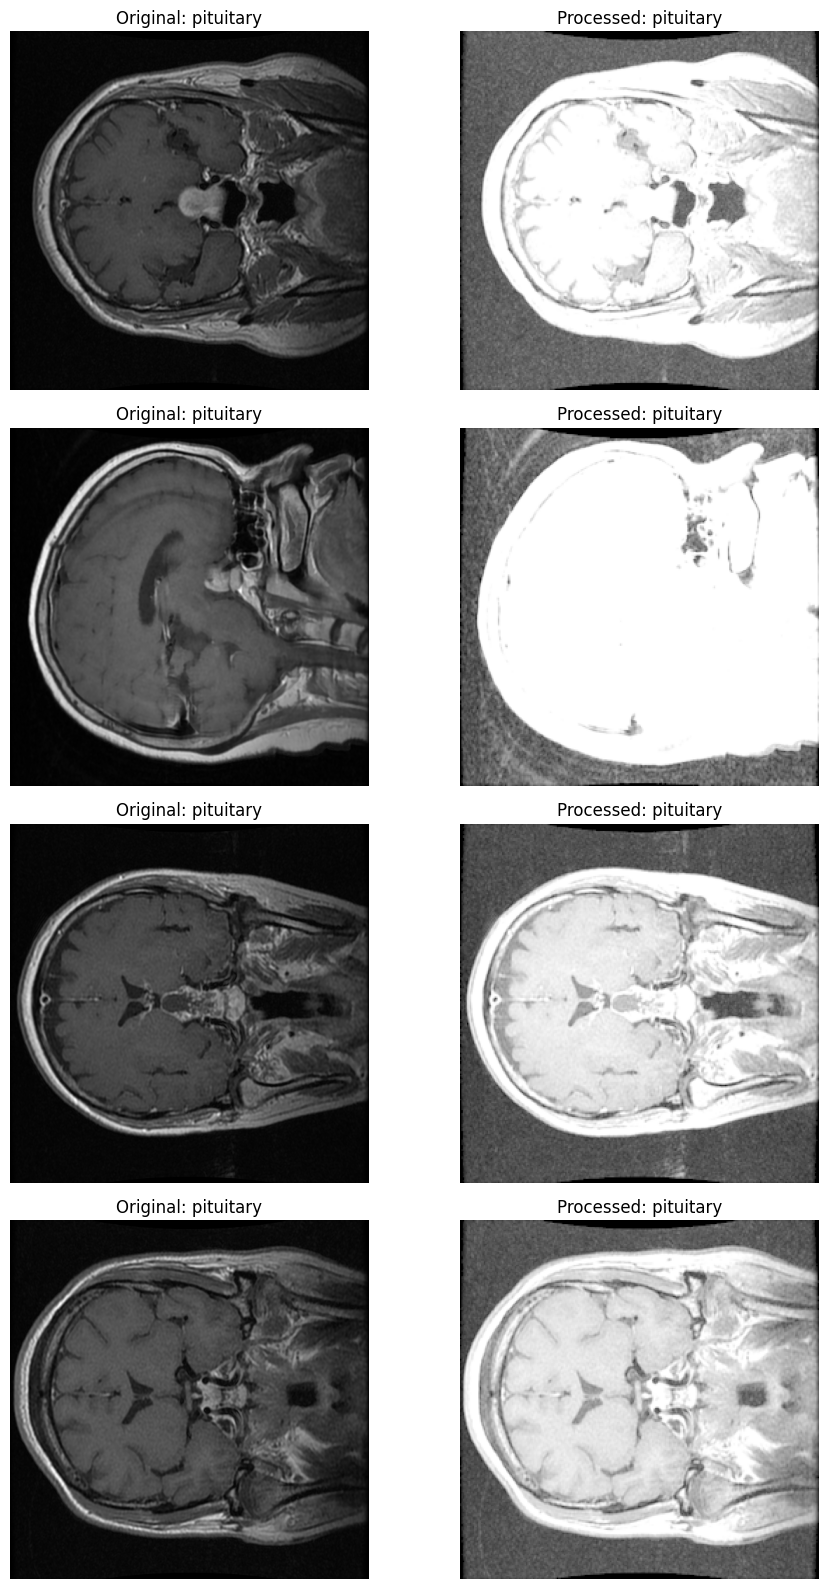

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dictionary mapping numeric labels to tumor types
label_dict = {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}

output_dir = '/content/brain_tumor_dataset/images'

def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((256, 256))
    img_array = np.array(img).astype(np.float32)

    # Percentile clipping (2 to 98)
    p2, p98 = np.percentile(img_array, (2, 98))
    img_array = np.clip(img_array, p2, p98)

    # Normalize to [0,1]
    img_array = (img_array - p2) / (p98 - p2)

    # Gamma correction (darken)
    gamma = 0.4
    img_array = np.power(img_array, gamma)

    return img_array

# Collect image paths and their labels
image_files = []
labels = []

for root, _, files in os.walk(output_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            label_num = os.path.basename(os.path.dirname(image_path))
            label_str = label_dict.get(int(label_num), "Unknown")
            image_files.append(image_path)
            labels.append(label_str)

# Show first 8 images with their processed versions side-by-side
num_images = min(4, len(image_files))
images_to_show = image_files[:num_images]
labels_to_show = labels[:num_images]

fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images))

for i, (img_path, label) in enumerate(zip(images_to_show, labels_to_show)):
    # Original image
    img = Image.open(img_path)
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"Original: {label}")
    axes[i, 0].axis('off')

    # Processed image
    proc_img = preprocess_image(img_path)
    axes[i, 1].imshow(proc_img, cmap='gray')
    axes[i, 1].set_title(f"Processed: {label}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image, ImageEnhance
import numpy as np

# Dictionary mapping numeric labels to tumor types
label_dict = {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}
output_dir = '/content/brain_tumor_dataset/images'

def preprocess_image(image_path):
    # Open image, convert to grayscale and resize
    img = Image.open(image_path).convert('L')
    img = img.resize((256, 256))

    # Apply sharpness enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.5)  # Adjust factor as needed

    # Convert to numpy array
    img_array = np.array(img).astype(np.float32)

    # Percentile clipping (2nd to 98th percentile) to reduce outliers
    p2, p98 = np.percentile(img_array, (2, 98))
    img_array = np.clip(img_array, p2, p98)

    # Normalize to [0,1]
    img_array = (img_array - p2) / (p98 - p2)

    # Gamma correction (darken)
    gamma = 0.7
    img_array = np.power(img_array, gamma)

    return img_array

processed_images = []
processed_labels = []

max_per_class = 100
count_per_class = {label: 0 for label in label_dict.keys()}

for label_num, label_name in label_dict.items():
    class_folder = os.path.join(output_dir, str(label_num))
    if not os.path.exists(class_folder):
        print(f"Folder not found: {class_folder}")
        continue

    files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in files:
        if count_per_class[label_num] >= max_per_class:
            break
        img_path = os.path.join(class_folder, file)
        try:
            processed_img = preprocess_image(img_path)
            processed_images.append(processed_img)
            processed_labels.append(label_name)
            count_per_class[label_num] += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

print("Processed images per class:", count_per_class)
print(f"Total processed images: {len(processed_images)}")


Processed images per class: {1: 100, 2: 100, 3: 100}
Total processed images: 300


In [ ]:
np.unique(processed_labels)

array(['glioma', 'meningioma', 'pituitary'], dtype='<U10')

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# processed_labels is a list of strings like 'meningioma', 'glioma', 'pituitary'

le = LabelEncoder()
numeric_labels = le.fit_transform(processed_labels)  # e.g. meningioma->0, glioma->1, pituitary->2

# If you want, you can save the mapping:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

numeric_labels = np.array(numeric_labels)
processed_images_rgb = np.stack([processed_images]*3, axis=-1)  # shape: (num_samples, 256,256,3)


Label mapping: {np.str_('glioma'): np.int64(0), np.str_('meningioma'): np.int64(1), np.str_('pituitary'): np.int64(2)}


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model

INPUT_SHAPE = (256, 256, 3)
num_classes = 3

base_model1 = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model1.input, outputs=output)

# Freeze base model layers (optional)
for layer in base_model1.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 127, 127,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 127, 127,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 125, 125,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 125, 125,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 125, 125,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 125, 125,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 125, 125,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 125, 125,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 125, 125,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 125, 125,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 63, 63,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 63, 63,    │          0 │ add[0][0]       

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, cohen_kappa_score,
                             matthews_corrcoef)
from scipy import stats
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# === Parameters ===
num_classes = 3
INPUT_SHAPE = (256, 256, 3)  # Assuming processed_images_rgb shape is consistent with this
EPOCHS = 3
BATCH_SIZE = 32

# Assume processed_images_rgb is your preprocessed RGB images as numpy array (N, 256, 256, 3)
# Assume numeric_labels is a numpy array of integer labels (N,) with values in [0, num_classes-1]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for fold metrics
fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'kappa': [],
    'mcc': [],
    'csi': [],
    'conf_matrices': [],
    'classification_reports': []
}

fold_no = 1

def compute_csi(conf_matrix):
    csi_per_class = []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        denom = TP + FN + FP
        csi = TP / denom if denom > 0 else 0
        csi_per_class.append(csi)
    return np.mean(csi_per_class)

def accuracy_confidence_interval(acc, n, confidence=0.95):
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    se = np.sqrt((acc * (1 - acc)) / n)
    lower = acc - z * se
    upper = acc + z * se
    return max(0, lower), min(1, upper)

for train_index, val_index in kf.split(processed_images_rgb):
    print(f"Training fold {fold_no}...")

    X_train, X_val = processed_images_rgb[train_index], processed_images_rgb[val_index]
    y_train, y_val = numeric_labels[train_index], numeric_labels[val_index]

    # Build model fresh for each fold
    base_model = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze base model layers (optional)
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
              validation_data=(X_val, y_val), verbose=2)

    # Predictions
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Basic metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

    # Additional metrics
    conf_mat = confusion_matrix(y_val, y_pred)
    class_report = classification_report(y_val, y_pred, zero_division=0)
    kappa = cohen_kappa_score(y_val, y_pred)
    mcc = matthews_corrcoef(y_val, y_pred)
    csi = compute_csi(conf_mat)
    ci_lower, ci_upper = accuracy_confidence_interval(acc, len(y_val))

    # Print metrics
    print(f"Fold {fold_no} metrics:")
    print(f"Accuracy: {acc:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}, MCC: {mcc:.4f}, CSI: {csi:.4f}")
    print("Confusion Matrix:")
    print(conf_mat)
    print("Classification Report:")
    print(class_report)

    # Save metrics for averaging/reporting later
    fold_metrics['accuracy'].append(acc)
    fold_metrics['precision'].append(prec)
    fold_metrics['recall'].append(rec)
    fold_metrics['f1_score'].append(f1)
    fold_metrics['kappa'].append(kappa)
    fold_metrics['mcc'].append(mcc)
    fold_metrics['csi'].append(csi)
    fold_metrics['conf_matrices'].append(conf_mat)
    fold_metrics['classification_reports'].append(class_report)

    fold_no += 1

# Average metrics over folds
print("\n=== 5-Fold Cross-Validation Average Results ===")
print(f"Average Accuracy: {np.mean(fold_metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(fold_metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(fold_metrics['recall']):.4f}")
print(f"Average F1 Score: {np.mean(fold_metrics['f1_score']):.4f}")
print(f"Average Cohen's Kappa: {np.mean(fold_metrics['kappa']):.4f}")
print(f"Average MCC: {np.mean(fold_metrics['mcc']):.4f}")
print(f"Average CSI: {np.mean(fold_metrics['csi']):.4f}")


Training fold 1...
Epoch 1/3
8/8 - 18s - 2s/step - accuracy: 0.4583 - loss: 1.0492 - val_accuracy: 0.6000 - val_loss: 0.9762
Epoch 2/3
8/8 - 9s - 1s/step - accuracy: 0.5875 - loss: 0.8751 - val_accuracy: 0.5667 - val_loss: 0.9384
Epoch 3/3
8/8 - 2s - 311ms/step - accuracy: 0.6333 - loss: 0.7629 - val_accuracy: 0.6000 - val_loss: 0.9203
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
Fold 1 metrics:
Accuracy: 0.6000 (95% CI: [0.4760, 0.7240])
Precision: 0.6362, Recall: 0.6000, F1 Score: 0.6025
Cohen's Kappa: 0.4059, MCC: 0.4157, CSI: 0.4319
Confusion Matrix:
[[12  2  2]
 [ 9 12  1]
 [ 3  7 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60        16
           1       0.57      0.55      0.56        22
           2       0.80      0.55      0.65        22

    accuracy                           0.60        60
   macro avg       0.62      0.61      0.60        60
weighted avg       0.64      0.60      0.60        60

Trainin

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Fold 2 metrics:
Accuracy: 0.6833 (95% CI: [0.5656, 0.8010])
Precision: 0.7035, Recall: 0.6833, F1 Score: 0.6762
Cohen's Kappa: 0.5254, MCC: 0.5370, CSI: 0.5179
Confusion Matrix:
[[17  3  3]
 [ 6 11  5]
 [ 2  0 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        23
           1       0.79      0.50      0.61        22
           2       0.62      0.87      0.72        15

    accuracy                           0.68        60
   macro avg       0.69      0.70      0.68        60
weighted avg       0.70      0.68      0.68        60

Training fold 3...
Epoch 1/3
8/8 - 15s - 2s/step - accuracy: 0.3500 - loss: 1.1845 - val_accuracy: 0.4500 - val_loss: 0.9720
Epoch 2/3
8/8 - 2s - 213ms/step - accuracy: 0.5000 - loss: 0.9735 - val_accuracy: 0.4167 - val_loss: 0.9357
Epoch 3/3
8/8 - 1s - 174ms/step - accuracy: 0.5458 - loss: 0.9036 - val_accuracy: 0.5667 - val_loss: 0.8343
2/2 

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, cohen_kappa_score,
                             matthews_corrcoef)
from scipy import stats
import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet50V2, ResNet152V2, InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# === Parameters ===
num_classes = 3
INPUT_SHAPE = (256, 256, 3)  # Adjust as needed
EPOCHS = 3
BATCH_SIZE = 32

# Assume these are your data arrays
# processed_images_rgb: np.array of shape (N, 256, 256, 3)
# numeric_labels: np.array of shape (N,) with integer labels [0, num_classes-1]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Model dictionary to loop over
base_models_dict = {
    'Xception': Xception,
    'ResNet50V2': ResNet50V2,
    'ResNet152V2': ResNet152V2,
    'InceptionResNetV2': InceptionResNetV2
}

def compute_csi(conf_matrix):
    csi_per_class = []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        denom = TP + FN + FP
        csi = TP / denom if denom > 0 else 0
        csi_per_class.append(csi)
    return np.mean(csi_per_class)

def accuracy_confidence_interval(acc, n, confidence=0.95):
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    se = np.sqrt((acc * (1 - acc)) / n)
    lower = acc - z * se
    upper = acc + z * se
    return max(0, lower), min(1, upper)

# To store results for each model
results = {model_name: {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'kappa': [],
    'mcc': [],
    'csi': [],
    'conf_matrices': [],
    'classification_reports': []
} for model_name in base_models_dict.keys()}

# Loop over folds
for fold_no, (train_index, val_index) in enumerate(kf.split(processed_images_rgb), 1):
    print(f"\n===== Fold {fold_no} =====")

    X_train, X_val = processed_images_rgb[train_index], processed_images_rgb[val_index]
    y_train, y_val = numeric_labels[train_index], numeric_labels[val_index]

    # Loop over each base model
    for model_name, base_model_func in base_models_dict.items():
        print(f"\nTraining with base model: {model_name}")

        # Build fresh model
        base_model = base_model_func(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=output)

        # Freeze base layers optionally
        for layer in base_model.layers:
            layer.trainable = False

        model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train
        model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                  validation_data=(X_val, y_val), verbose=2)

        # Predict
        y_pred_probs = model.predict(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Metrics
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        conf_mat = confusion_matrix(y_val, y_pred)
        class_report = classification_report(y_val, y_pred, zero_division=0)
        kappa = cohen_kappa_score(y_val, y_pred)
        mcc = matthews_corrcoef(y_val, y_pred)
        csi = compute_csi(conf_mat)
        ci_lower, ci_upper = accuracy_confidence_interval(acc, len(y_val))

        print(f"Metrics for {model_name} on fold {fold_no}:")
        print(f"Accuracy: {acc:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
        print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
        print(f"Cohen's Kappa: {kappa:.4f}, MCC: {mcc:.4f}, CSI: {csi:.4f}")
        print("Confusion Matrix:")
        print(conf_mat)
        print("Classification Report:")
        print(class_report)

        # Save metrics for averages
        results[model_name]['accuracy'].append(acc)
        results[model_name]['precision'].append(prec)
        results[model_name]['recall'].append(rec)
        results[model_name]['f1_score'].append(f1)
        results[model_name]['kappa'].append(kappa)
        results[model_name]['mcc'].append(mcc)
        results[model_name]['csi'].append(csi)
        results[model_name]['conf_matrices'].append(conf_mat)
        results[model_name]['classification_reports'].append(class_report)

# After all folds & models are done, print average results per model
print("\n\n=== Average 5-Fold CV Results per Model ===")
for model_name in base_models_dict.keys():
    print(f"\nModel: {model_name}")
    print(f"Average Accuracy: {np.mean(results[model_name]['accuracy']):.4f}")
    print(f"Average Precision: {np.mean(results[model_name]['precision']):.4f}")
    print(f"Average Recall: {np.mean(results[model_name]['recall']):.4f}")
    print(f"Average F1 Score: {np.mean(results[model_name]['f1_score']):.4f}")
    print(f"Average Cohen's Kappa: {np.mean(results[model_name]['kappa']):.4f}")
    print(f"Average MCC: {np.mean(results[model_name]['mcc']):.4f}")
    print(f"Average CSI: {np.mean(results[model_name]['csi']):.4f}")



===== Fold 1 =====

Training with base model: Xception
Epoch 1/3
8/8 - 19s - 2s/step - accuracy: 0.3875 - loss: 1.1148 - val_accuracy: 0.4667 - val_loss: 0.9912
Epoch 2/3
8/8 - 2s - 192ms/step - accuracy: 0.5417 - loss: 0.9535 - val_accuracy: 0.4667 - val_loss: 0.9794
Epoch 3/3
8/8 - 2s - 299ms/step - accuracy: 0.6292 - loss: 0.8326 - val_accuracy: 0.5333 - val_loss: 0.9747
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Metrics for Xception on fold 1:
Accuracy: 0.5333 (95% CI: [0.4071, 0.6596])
Precision: 0.5966, Recall: 0.5333, F1 Score: 0.5419
Cohen's Kappa: 0.3120, MCC: 0.3250, CSI: 0.3750
Confusion Matrix:
[[11  4  1]
 [12  9  1]
 [ 4  6 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.69      0.51        16
           1       0.47      0.41      0.44        22
           2       0.86      0.55      0.67        22

    accuracy                           0.53        60
   macro avg       0.58      0.55      0.54        60
weight

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet50V2, ResNet152V2, InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from itertools import product

# === Parameters ===
num_classes = 3
INPUT_SHAPE = (256, 256, 3)
EPOCHS = 3
BATCH_SIZE = 32

kf = KFold(n_splits=5, shuffle=True, random_state=42)

base_models_dict = {
    'Xception': Xception,
    'ResNet50V2': ResNet50V2,
    'ResNet152V2': ResNet152V2,
    'InceptionResNetV2': InceptionResNetV2
}

# Build model function for reusability
def build_model(base_model_func):
    base_model = base_model_func(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Generate all possible weight combinations with step 0.1 summing to 1
def generate_weight_combinations(step=0.1):
    weights_range = np.arange(0, 1 + step, step)
    combos = []
    for combo in product(weights_range, repeat=4):
        if abs(sum(combo) - 1.0) < 1e-6:
            combos.append(combo)
    return combos

weight_combinations = generate_weight_combinations(0.1)

fold_no = 1
fold_metrics = []
fold_best_weights = []

for train_idx, val_idx in kf.split(processed_images_rgb):
    print(f"\n=== Fold {fold_no} ===")

    X_train, X_val = processed_images_rgb[train_idx], processed_images_rgb[val_idx]
    y_train, y_val = numeric_labels[train_idx], numeric_labels[val_idx]

    # Train each model and predict probs
    model_preds = {}
    for model_name, base_model_func in base_models_dict.items():
        print(f"Training {model_name}...")
        model = build_model(base_model_func)
        model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=2)
        preds = model.predict(X_val)  # shape (val_samples, num_classes)
        model_preds[model_name] = preds

    # Grid search over weights for best accuracy (can change metric)
    best_acc = 0
    best_weights = None
    best_weighted_pred = None

    for weights in weight_combinations:
        # Weighted sum of predictions from all models
        weighted_preds = np.zeros_like(model_preds['Xception'])
        for w, model_name in zip(weights, base_models_dict.keys()):
            weighted_preds += w * model_preds[model_name]

        weighted_pred_labels = np.argmax(weighted_preds, axis=1)
        acc = accuracy_score(y_val, weighted_pred_labels)

        if acc > best_acc:
            best_acc = acc
            best_weights = weights
            best_weighted_pred = weighted_pred_labels

    print(f"Best weights for fold {fold_no}: {best_weights} with Accuracy: {best_acc:.4f}")

    # Store fold results
    fold_metrics.append({
        'accuracy': best_acc,
        'weights': best_weights
    })
    fold_best_weights.append(best_weights)

    fold_no += 1
    break

# Summarize results
avg_accuracy = np.mean([m['accuracy'] for m in fold_metrics])
print("\n=== Final results over all folds ===")
print(f"Average Weighted Accuracy: {avg_accuracy:.4f}")
print("Weights chosen per fold:")
for i, w in enumerate(fold_best_weights, 1):
    print(f"Fold {i}: {w}")




import numpy as np
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
import random

# GA parameters
POP_SIZE = 50
NGEN = 40
CXPB = 0.7  # Crossover probability
MUTPB = 0.2  # Mutation probability

def ga_optimize_weights(model_preds, y_true):
    """
    model_preds: dict of model_name -> np.array of shape (samples, classes)
    y_true: true labels array of shape (samples,)

    Returns: best weights (tuple of length 4) that maximize accuracy.
    """

    # Fitness function: maximize accuracy of weighted sum
    def fitness(individual):
        weights = np.array(individual)
        weights = weights / weights.sum()  # normalize weights to sum=1
        combined_pred = np.zeros_like(list(model_preds.values())[0])
        for w, pred in zip(weights, model_preds.values()):
            combined_pred += w * pred
        pred_labels = np.argmax(combined_pred, axis=1)
        acc = accuracy_score(y_true, pred_labels)
        return (acc,)  # DEAP expects fitness to be a tuple

    # Set up GA with DEAP
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximize accuracy
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    # Each individual is 4 weights initialized randomly between 0 and 1
    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=POP_SIZE)

    # Apply genetic algorithm
    hof = tools.HallOfFame(1)  # Keep best individual

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                        stats=stats, halloffame=hof, verbose=False)

    # Normalize best weights to sum=1
    best_weights = np.array(hof[0])
    best_weights /= best_weights.sum()

    return tuple(best_weights)


# === Inside your fold training loop, after you train all 4 models and get predictions ===

for train_idx, val_idx in kf.split(processed_images_rgb):
    print(f"\n=== Fold {fold_no} ===")

    X_train, X_val = processed_images_rgb[train_idx], processed_images_rgb[val_idx]
    y_train, y_val = numeric_labels[train_idx], numeric_labels[val_idx]

    model_preds = {}
    for model_name, base_model_func in base_models_dict.items():
        print(f"Training {model_name}...")
        model = build_model(base_model_func)
        model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=2)
        preds = model.predict(X_val)
        model_preds[model_name] = preds

    # GA optimization of weights
    best_weights = ga_optimize_weights(model_preds, y_val)

    print(f"Best GA weights for fold {fold_no}: {best_weights}")

    # Calculate final predictions using best weights
    combined_preds = np.zeros_like(list(model_preds.values())[0])
    for w, pred in zip(best_weights, model_preds.values()):
        combined_preds += w * pred
    pred_labels = np.argmax(combined_preds, axis=1)

    acc = accuracy_score(y_val, pred_labels)
    f1 = f1_score(y_val, pred_labels, average='weighted')

    print(f"Fold {fold_no} - Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    fold_metrics.append({'accuracy': acc, 'f1_score': f1, 'weights': best_weights})

    fold_no += 1



=== Fold 1 ===
Training Xception...
Epoch 1/3
8/8 - 30s - 4s/step - accuracy: 0.3625 - loss: 1.1847 - val_accuracy: 0.3833 - val_loss: 1.0466
Epoch 2/3
8/8 - 1s - 178ms/step - accuracy: 0.5292 - loss: 0.9701 - val_accuracy: 0.4667 - val_loss: 0.9505
Epoch 3/3
8/8 - 1s - 182ms/step - accuracy: 0.5667 - loss: 0.8728 - val_accuracy: 0.5333 - val_loss: 0.9241
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
Training ResNet50V2...
Epoch 1/3
8/8 - 31s - 4s/step - accuracy: 0.3875 - loss: 1.6441 - val_accuracy: 0.4167 - val_loss: 1.1066
Epoch 2/3
8/8 - 19s - 2s/step - accuracy: 0.4792 - loss: 1.1880 - val_accuracy: 0.5000 - val_loss: 1.0721
Epoch 3/3
8/8 - 1s - 98ms/step - accuracy: 0.5292 - loss: 0.9964 - val_accuracy: 0.5833 - val_loss: 1.0386
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Training ResNet152V2...
Epoch 1/3
8/8 - 47s - 6s/step - accuracy: 0.3375 - loss: 1.6497 - val_accuracy: 0.4000 - val_loss: 1.1154
Epoch 2/3
8/8 - 2s - 243ms/step - accuracy: 0.4958 - loss: 1.2451 - val_accuracy: 0.4500 - val_lo

1/2 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step
Training InceptionResNetV2...
Epoch 1/3
8/8 - 80s - 10s/step - accuracy: 0.3667 - loss: 1.3350 - val_accuracy: 0.4833 - val_loss: 1.0028
Epoch 2/3
8/8 - 28s - 4s/step - accuracy: 0.4458 - loss: 1.2129 - val_accuracy: 0.4333 - val_loss: 0.9461
Epoch 3/3
8/8 - 2s - 307ms/step - accuracy: 0.5042 - loss: 1.1508 - val_accuracy: 0.5333 - val_loss: 0.8980
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 12s/step
Best weights for fold 1: (np.float64(0.4), np.float64(0.1), np.float64(0.1), np.float64(0.4)) with Accuracy: 0.6333

=== Final results over all folds ===
Average Weighted Accuracy: 0.6333
Weights chosen per fold:
Fold 1: (np.float64(0.4), np.float64(0.1), np.float64(0.1), np.float64(0.4))


In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
import random

# GA parameters
POP_SIZE = 50
NGEN = 40
CXPB = 0.7  # Crossover probability
MUTPB = 0.2  # Mutation probability

def ga_optimize_weights(model_preds, y_true):
    """
    model_preds: dict of model_name -> np.array of shape (samples, classes)
    y_true: true labels array of shape (samples,)

    Returns: best weights (tuple of length 4) that maximize accuracy.
    """

    # Fitness function: maximize accuracy of weighted sum
    def fitness(individual):
        weights = np.array(individual)
        weights = weights / weights.sum()  # normalize weights to sum=1
        combined_pred = np.zeros_like(list(model_preds.values())[0])
        for w, pred in zip(weights, model_preds.values()):
            combined_pred += w * pred
        pred_labels = np.argmax(combined_pred, axis=1)
        acc = accuracy_score(y_true, pred_labels)
        return (acc,)  # DEAP expects fitness to be a tuple

    # Set up GA with DEAP
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximize accuracy
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    # Each individual is 4 weights initialized randomly between 0 and 1
    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=POP_SIZE)

    # Apply genetic algorithm
    hof = tools.HallOfFame(1)  # Keep best individual

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                        stats=stats, halloffame=hof, verbose=False)

    # Normalize best weights to sum=1
    best_weights = np.array(hof[0])
    best_weights /= best_weights.sum()

    return tuple(best_weights)


# === Inside your fold training loop, after you train all 4 models and get predictions ===

for train_idx, val_idx in kf.split(processed_images_rgb):
    print(f"\n=== Fold {fold_no} ===")

    X_train, X_val = processed_images_rgb[train_idx], processed_images_rgb[val_idx]
    y_train, y_val = numeric_labels[train_idx], numeric_labels[val_idx]

    model_preds = {}
    for model_name, base_model_func in base_models_dict.items():
        print(f"Training {model_name}...")
        model = build_model(base_model_func)
        model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=2)
        preds = model.predict(X_val)
        model_preds[model_name] = preds

    # GA optimization of weights
    best_weights = ga_optimize_weights(model_preds, y_val)

    print(f"Best GA weights for fold {fold_no}: {best_weights}")

    # Calculate final predictions using best weights
    combined_preds = np.zeros_like(list(model_preds.values())[0])
    for w, pred in zip(best_weights, model_preds.values()):
        combined_preds += w * pred
    pred_labels = np.argmax(combined_preds, axis=1)

    acc = accuracy_score(y_val, pred_labels)
    f1 = f1_score(y_val, pred_labels, average='weighted')

    print(f"Fold {fold_no} - Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    fold_metrics.append({'accuracy': acc, 'f1_score': f1, 'weights': best_weights})

    fold_no += 1



ModuleNotFoundError: No module named 'deap'

In [ ]:
import numpy as np
import random
import os
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, cohen_kappa_score, matthews_corrcoef
from tensorflow.keras.applications import Xception, ResNet50V2, ResNet152V2, InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools, algorithms

# Parameters
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32
EPOCHS = 3
NUM_CLASSES = 3

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Models dictionary
base_models_dict = {
    "Xception": Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE),
    "ResNet50V2": ResNet50V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE),
    "ResNet152V2": ResNet152V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE),
    "InceptionResNetV2": InceptionResNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
}

# GA Parameters
POP_SIZE = 50
NGEN = 40
CXPB = 0.7
MUTPB = 0.2

# Grid search weight space (0.1 increments, constrained to sum=1)
weight_space = np.round(np.linspace(0, 1, 11), 2)
weight_combinations = [(w1, w2, w3, w4) for w1 in weight_space for w2 in weight_space
                       for w3 in weight_space for w4 in weight_space
                       if np.isclose(w1 + w2 + w3 + w4, 1)]

fold_metrics = []
fold_no = 1

# Define the model building function
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# GA Optimization Function
def ga_optimize_weights(model_preds, y_true):
    """
    GA optimization of ensemble weights.
    """
    def fitness(individual):
        weights = np.array(individual)
        weights /= weights.sum()
        combined_pred = np.zeros_like(list(model_preds.values())[0])
        for w, pred in zip(weights, model_preds.values()):
            combined_pred += w * pred
        pred_labels = np.argmax(combined_pred, axis=1)
        return (accuracy_score(y_true, pred_labels),)

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, halloffame=hof, verbose=False)
    best_weights = np.array(hof[0])
    best_weights /= best_weights.sum()
    return tuple(best_weights)

# Training Loop
for train_idx, val_idx in kf.split(processed_images_rgb):
    print(f"\n=== Fold {fold_no} ===")

    X_train, X_val = processed_images_rgb[train_idx], processed_images_rgb[val_idx]
    y_train, y_val = numeric_labels[train_idx], numeric_labels[val_idx]

    model_preds = {}

    # Train and store predictions for each model
    for model_name, base_model_func in base_models_dict.items():
        print(f"Training {model_name}...")
        model = build_model(base_model_func)
        model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=2)
        preds = model.predict(X_val)
        model_preds[model_name] = preds

    # Grid Search
    print("Performing Grid Search...")
    best_acc = -1
    best_weights_grid = None

    for weights in weight_combinations:
        combined_pred = np.zeros_like(list(model_preds.values())[0])
        for w, pred in zip(weights, model_preds.values()):
            combined_pred += w * pred
        pred_labels = np.argmax(combined_pred, axis=1)
        acc = accuracy_score(y_val, pred_labels)
        if acc > best_acc:
            best_acc = acc
            best_weights_grid = weights

    print(f"Best Grid Search Weights: {best_weights_grid}, Accuracy: {best_acc:.4f}")

    # GA Optimization
    print("Performing GA Optimization...")
    best_weights_ga = ga_optimize_weights(model_preds, y_val)
    print(f"Best GA Weights: {best_weights_ga}")

    # Evaluate Grid and GA
    for method, weights in zip(["Grid Search", "GA"], [best_weights_grid, best_weights_ga]):
        combined_pred = np.zeros_like(list(model_preds.values())[0])
        for w, pred in zip(weights, model_preds.values()):
            combined_pred += w * pred
        pred_labels = np.argmax(combined_pred, axis=1)

        acc = accuracy_score(y_val, pred_labels)
        f1 = f1_score(y_val, pred_labels, average='weighted')
        prec = precision_score(y_val, pred_labels, average='weighted')
        rec = recall_score(y_val, pred_labels, average='weighted')
        kappa = cohen_kappa_score(y_val, pred_labels)
        mcc = matthews_corrcoef(y_val, pred_labels)
        cm = confusion_matrix(y_val, pred_labels)

        print(f"\n{method} - Fold {fold_no} Metrics:")
        print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
        print(f"Kappa: {kappa:.4f}, MCC: {mcc:.4f}")
        print(f"Confusion Matrix:\n{cm}")

        fold_metrics.append({
            'fold': fold_no,
            'method': method,
            'weights': weights,
            'accuracy': acc,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'kappa': kappa,
            'mcc': mcc,
            'conf_matrix': cm.tolist()
        })

    fold_no += 1

    break

# Average metrics across folds
for method in ["Grid Search", "GA"]:
    method_metrics = [m for m in fold_metrics if m['method'] == method]
    avg_acc = np.mean([m['accuracy'] for m in method_metrics])
    avg_f1 = np.mean([m['f1_score'] for m in method_metrics])

    print(f"\n=== {method} - Average Metrics Across Folds ===")
    print(f"Average Accuracy: {avg_acc:.4f}, Average F1 Score: {avg_f1:.4f}")



=== Fold 1 ===
Training Xception...
Epoch 1/3
8/8 - 18s - 2s/step - accuracy: 0.3750 - loss: 1.1430 - val_accuracy: 0.5167 - val_loss: 0.9758
Epoch 2/3
8/8 - 8s - 1s/step - accuracy: 0.5583 - loss: 0.9177 - val_accuracy: 0.5167 - val_loss: 0.9420
Epoch 3/3
8/8 - 2s - 190ms/step - accuracy: 0.5833 - loss: 0.8578 - val_accuracy: 0.5167 - val_loss: 0.9470
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Training ResNet50V2...
Epoch 1/3
8/8 - 20s - 3s/step - accuracy: 0.3958 - loss: 1.6389 - val_accuracy: 0.3667 - val_loss: 1.1488
Epoch 2/3
8/8 - 8s - 1s/step - accuracy: 0.4167 - loss: 1.2866 - val_accuracy: 0.5500 - val_loss: 1.0149
Epoch 3/3
8/8 - 1s - 139ms/step - accuracy: 0.5500 - loss: 0.9642 - val_accuracy: 0.5333 - val_loss: 0.9913
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Training ResNet152V2...
Epoch 1/3
8/8 - 51s - 6s/step - accuracy: 0.4417 - loss: 1.4611 - val_accuracy: 0.6000 - val_loss: 0.9519
Epoch 2/3
8/8 - 12s - 2s/step - accuracy: 0.4750 - loss: 1.2387 - val_accuracy: 0.6000 - val_loss: 0

In [ ]:
best_weights_grid

(np.float64(0.3), np.float64(0.0), np.float64(0.6), np.float64(0.1))

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import Xception, ResNet50V2, ResNet152V2, InceptionResNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.xception import preprocess_input
import tensorflow as tf

# Test image path (modify with actual test image path)
TEST_IMAGE_PATH = '/content/brain_tumor_dataset/images/1/10.png'

# Example weights for Xception, ResNet50V2, ResNet152V2, InceptionResNetV2
best_weights_grid = [0.93, 0.925, 0.92, 0.925] # SAMPLE WEIGHTS

# Number of classes
NUM_CLASSES = 3
INPUT_SHAPE = (256, 256, 3)

# ✅ Preprocessing the test image for model prediction
def preprocess_image(img_path):
    img = load_img(img_path, target_size=INPUT_SHAPE[:2])
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)  # Model-specific preprocessing
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# ✅ Function to read and prepare the original image for display
def load_original_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to read image from {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, INPUT_SHAPE[:2])
    img = img.astype('float32') / 255.0  # Normalize for display
    return img

# Load and preprocess the test image
img_array = preprocess_image(TEST_IMAGE_PATH)
original_img = load_original_image(TEST_IMAGE_PATH)

# ✅ Models dictionary with the same order as the weights
models_dict = {
    "Xception": Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE),
    "ResNet50V2": ResNet50V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE),
    "ResNet152V2": ResNet152V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE),
    "InceptionResNetV2": InceptionResNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
}

# ✅ Build the top layers for each model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# ✅ Load the models
ensemble_models = {name: build_model(model) for name, model in models_dict.items()}

# ✅ Weighted ensemble prediction
def weighted_ensemble_prediction(models, img_array, weights):
    preds = np.zeros((1, NUM_CLASSES))
    for (model_name, model), weight in zip(models.items(), weights):
        pred = model.predict(img_array)
        preds += weight * pred
    return preds

# ✅ Grad-CAM Implementation
def get_gradcam_heatmap(model, img_array, class_idx, last_conv_layer_name):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# ✅ Overlay heatmap on the original image
def overlay_heatmap(original_img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted((original_img * 255).astype(np.uint8), alpha, heatmap, 1 - alpha, 0)
    return overlay

# ✅ Get the predicted class from the ensemble
ensemble_pred = weighted_ensemble_prediction(ensemble_models, img_array, best_weights_grid)
predicted_class = np.argmax(ensemble_pred[0])

# ✅ Last convolutional layer names for each model
last_conv_layers = {
    "Xception": "block14_sepconv2_act",
    "ResNet50V2": "conv5_block3_out",
    "ResNet152V2": "conv5_block3_out",
    "InceptionResNetV2": "conv_7b_ac"
}

# ✅ Generate and display Grad-CAM visualizations
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (model_name, model) in enumerate(ensemble_models.items()):
    print(f"Generating Grad-CAM for {model_name}...")
    last_conv_layer_name = last_conv_layers[model_name]
    heatmap = get_gradcam_heatmap(model, img_array, predicted_class, last_conv_layer_name)
    overlay_img = overlay_heatmap(original_img, heatmap)

    # Original Image
    axes[i * 2].imshow(original_img)
    axes[i * 2].set_title(f"Original - {model_name}")
    axes[i * 2].axis('off')

    # Grad-CAM Image
    axes[i * 2 + 1].imshow(overlay_img)
    axes[i * 2 + 1].set_title(f"Grad-CAM - {model_name}")
    axes[i * 2 + 1].axis('off')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 